# Analysis
This notebook does an initial analysis on the data processed in the ```process_data.ipynb```. The main signals analysed are Newcomers, Edits and Reverts.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_PATH = '/dlabdata1/turkish_wiki'

## 1) Newcomers
### General statistics

In [4]:
# Load all registrations and process dates
all_registrations = pd.read_csv(f'{DATA_PATH}/processed_data/all_registrations.csv')
all_registrations['date'] = pd.to_datetime(all_registrations['date'],   utc = True)
all_registrations = all_registrations.set_index('date')

In [5]:
# Get Yearly registrations
yearly_registrations = all_registrations.groupby(pd.Grouper(freq= 'Y')).count().reset_index()
yearly_registrations.date = yearly_registrations.date.dt.strftime("%Y")
yearly_registrations.columns = ['Year', 'New Users']

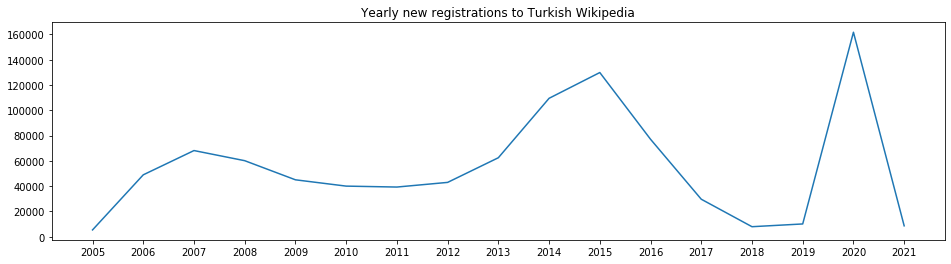

In [6]:
plt.figure(figsize=(16,4))
plt.title("Yearly new registrations to Turkish Wikipedia")
plt.plot(yearly_registrations['Year'], yearly_registrations['New Users'])
plt.show()

New registrations was already down from its' peak in 2015 by the year 2016. The ban of 2017 is quite a shock for the number of newcomers. The yearly registrations decreased to the days of the early internet. A huge recovery is seen in 2020 after that the ban was lifted.

In [7]:
# Dates on which the ban happened and got lifted
block_dates = [pd.to_datetime('2017-04-29', utc = True), pd.to_datetime('2020-01-15', utc = True)]
# Number of days where Wikipedia was blocked
blocked_days = (block_dates[1] - block_dates[0]).days

In [8]:
daily_registrations = all_registrations.groupby(pd.Grouper(freq= 'D')).count().reset_index()
daily_registrations.columns = ['Day', 'New Users']

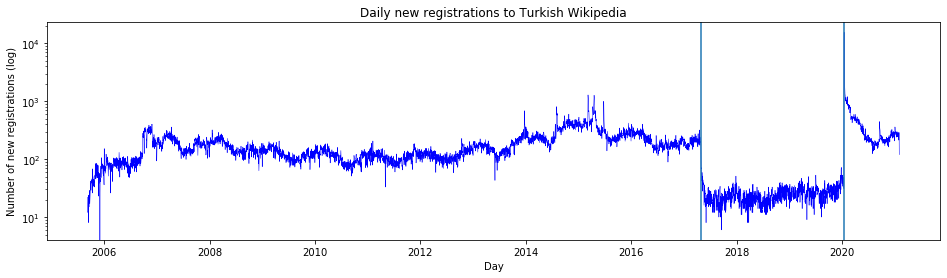

In [9]:
plt.figure(figsize=(16,4))
plt.title("Daily new registrations to Turkish Wikipedia")
plt.plot(daily_registrations['Day'].values, daily_registrations['New Users'], color='blue', lw=0.5)
plt.ylabel("Number of new registrations (log)")
plt.xlabel("Day")
for date in block_dates:
    plt.axvline(date)
plt.yscale('log')
plt.show()

A closer look on the daily registrations in log scale highlights the severity of the block. A very sharp decrease and a very sharp increase is observed at the days where Wikipedia got blocked/unblocked. The arrival of new users doesn't seem to increase much after the initial shock of the block. After the sharp increase of new users at the day of the unblock, new users registrations seem to reach historical levels, stablizing at the pre-block levels after a steady decrease.

In [10]:
# Daily number of new users (top 5)
daily_registrations.sort_values('New Users', ascending= False).head()

,Day,New Users
5243,2020-01-16 00:00:00+00:00,15531
5242,2020-01-15 00:00:00+00:00,9230
5244,2020-01-17 00:00:00+00:00,4504
5245,2020-01-18 00:00:00+00:00,2485
5246,2020-01-19 00:00:00+00:00,2021


In [11]:
# Daily number of new users before the ban (top 5 days)
daily_registrations[daily_registrations['Day'] < block_dates[0]].sort_values('New Users', ascending= False).head()

,Day,New Users
3468,2015-03-08 00:00:00+00:00,1285
3510,2015-04-19 00:00:00+00:00,1269
3469,2015-03-09 00:00:00+00:00,1180
3511,2015-04-20 00:00:00+00:00,1166
3509,2015-04-18 00:00:00+00:00,1137


We can see that the day where the ban was lifted, we observe more than 10 times the number of new registrations than the previous highs.

In [12]:
# Have symmetric before and after block intervals
days_after_block = (daily_registrations['Day'].max()-block_dates[1]).days
daily_registrations = daily_registrations[daily_registrations['Day'] >= block_dates[0]-pd.Timedelta(days=days_after_block)]

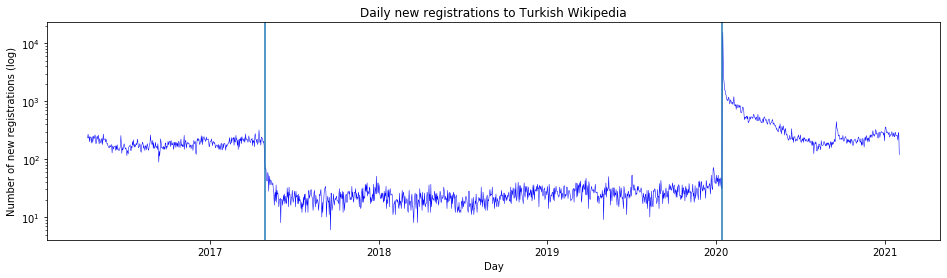

In [13]:
plt.figure(figsize=(16,4))
plt.title("Daily new registrations to Turkish Wikipedia")
plt.plot(daily_registrations['Day'].values, daily_registrations['New Users'], color='blue', lw=0.5)
plt.ylabel("Number of new registrations (log)")
plt.xlabel("Day")
for date in block_dates:
    plt.axvline(date)
plt.yscale('log')
plt.show()

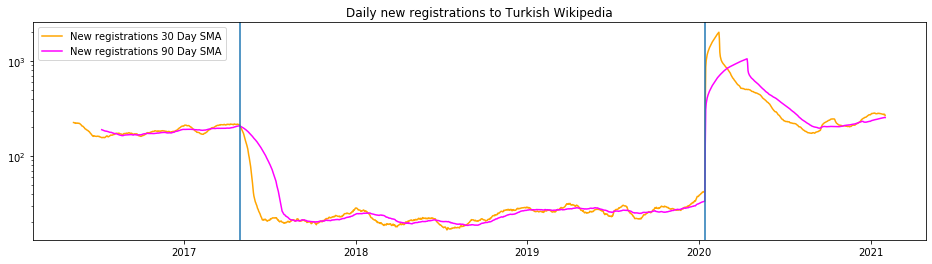

In [15]:
plt.figure(figsize=(16,4))
plt.title("Daily new registrations to Turkish Wikipedia")
rolling_mean = daily_registrations['New Users'].rolling(window=30).mean()
rolling_mean2 = daily_registrations['New Users'].rolling(window=90).mean()
plt.plot(daily_registrations['Day'].values, rolling_mean, label='New registrations 30 Day SMA', color='orange')
plt.plot(daily_registrations['Day'].values, rolling_mean2, label='New registrations 90 Day SMA', color='magenta')
plt.legend(loc='upper left')
for date in block_dates:
    plt.axvline(date)
plt.yscale('log')
plt.show()

In [16]:
daily_registrations['period'] = daily_registrations.apply(lambda row: 'pre-block' if row['Day'] < block_dates[0] else 'block' if not row['Day'] >= block_dates[1] else 'after-block', axis=1)

In [17]:
groups = daily_registrations.groupby('period')
periods = pd.concat([pd.DataFrame(x[1]['New Users'].values) for x in groups], axis=1)
periods = pd.DataFrame(periods)
periods.columns = range(1,4)

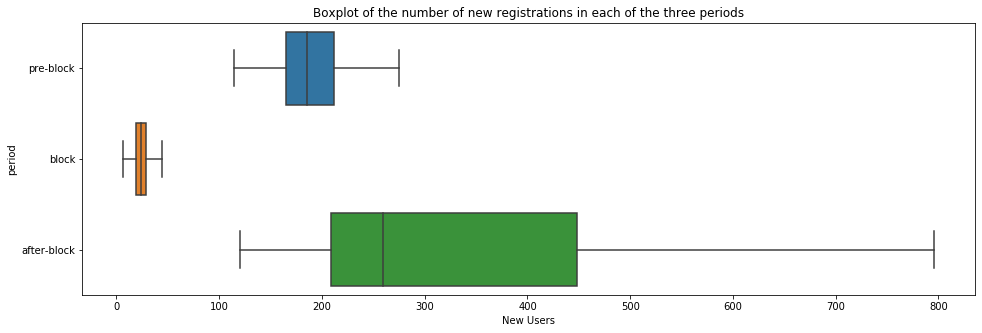

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
plt.title('Boxplot of the number of new registrations in each of the three periods')
plt.xlabel('Daily New Users')
ax = sns.boxplot(y="period", x="New Users", data=daily_registrations,  showfliers=False)

### Hour of the day of registrations
It may be interesting to look at the hour of the day of registrations in the three periods to see if there is any evidence of internalization among Wikipedians in the post-block period. If we see a significant change in the distribution of the registration hours, we might infer that the new registrations mostly come from Turkish speakers who live outside of Turkey.

In [20]:
all_registrations = all_registrations.reset_index()

In [21]:
all_registrations['Hour'] = all_registrations.date.dt.strftime("%H")

In [22]:
hourly_registrations = all_registrations[all_registrations['date'] >= block_dates[0]-pd.Timedelta(days=days_after_block)]

In [23]:
hourly_registrations['period'] = hourly_registrations.apply(lambda row: 'pre-block' if row['date'] < block_dates[0] else 'block' if not row['date'] >= block_dates[1] else 'after-block', axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
hourly_registrations = hourly_registrations.groupby(['period', 'Hour']).count()[['date']]

In [25]:
hourly_registrations.columns = ['count']

In [26]:
hourly_registrations['percent'] =  hourly_registrations['count'].div(hourly_registrations['count'].sum(level=0),level=0)

In [27]:
hourly_registrations = hourly_registrations.reset_index()

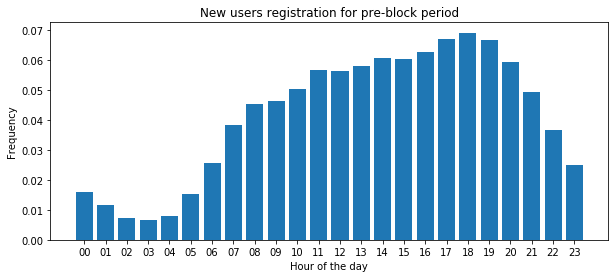

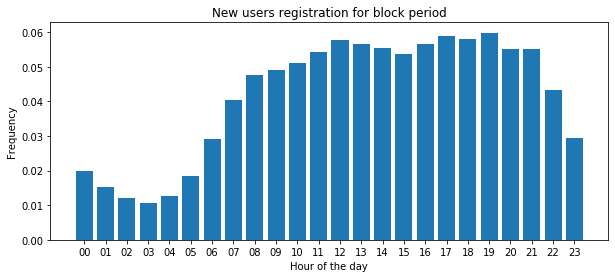

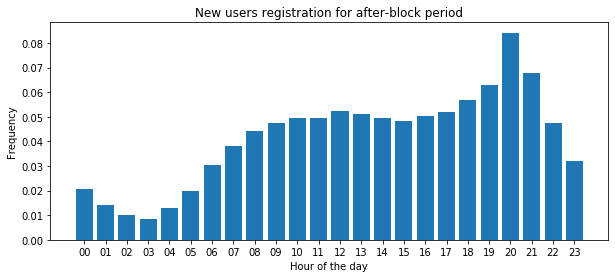

In [28]:
for period in ['pre-block', 'block', 'after-block']:
    plt.figure(figsize=(10,4))
    plt.bar(hourly_registrations[hourly_registrations.period == period]['Hour'],hourly_registrations[hourly_registrations.period == period]['percent'], label="Data 1")

    # The following commands add labels to our figure.
    plt.xlabel('Hour of the day')
    plt.ylabel('Frequency')
    plt.title(f'New users registration for {period} period')

    plt.show()

A shift is observed in the three periods.

Comparing the pre-block period to the block period, we see that in the block period there are two peaks of the distribution. This may be an evidence of internalization. We must dig deeper in the data to know if the new registrations came from Turkey or outside of Turkey. Detecting if editors come from Turkey or outside using this method can be hard as most of turkish diaspora outside of Turkey lives in Europe, so the time difference is small. 
One more thing to consider is the timezone change that happened in Turkey around the same period. See the corresponding article on [Wikipedia](https://en.wikipedia.org/wiki/Time_in_Turkey#:~:text=In%20October%202017%2C%20the%20Turkish,time%20zone%20for%20the%20country) and on this [website](https://www.timeanddate.com/news/time/turkey-scraps-dst-2016.html). The 30th of October 2016, while most of the countries using Daylight Saving Time set their clocks back 1 hour, Turkey stopped doing this.

## 2) Edits
### General edit statistics

In [29]:
edits = pd.read_csv(f'{DATA_PATH}/processed_data/edits.csv')

In [30]:
edits

,date,page_id,user_kind,event_user_id,revision_text_bytes
0,2002-12-05,5,account,1,24
1,2002-12-05,2740662,anonymous,2,1819
2,2002-12-13,2740662,anonymous,2,1781
3,2002-12-16,2740662,anonymous,2,4766
4,2002-12-17,2740662,anonymous,1,4310
...,...,...,...,...,...
12753708,2021-02-01,2908802,account,1,801
12753709,2021-02-01,2908803,account,2,1644
12753710,2021-02-01,2908804,account,2,1644
12753711,2021-02-01,2908814,account,4,18836


In [31]:
edits.columns = ["date", "page_id", "user_kind", "number_of_edits", "total_edited_bytes"]

In [32]:
edits['date'] = pd.to_datetime(edits['date'],   utc = True)

In [33]:
edits['user_kind'] = edits["user_kind"].astype("category")

In [34]:
daily_edits = edits.groupby(['date', 'user_kind']).agg({'number_of_edits': 'sum', 'total_edited_bytes': 'sum'})

In [35]:
daily_edits = daily_edits.reset_index()

In [36]:
yearly_edits =  daily_edits.groupby([daily_edits.date.dt.year, 'user_kind']).sum().reset_index()

In [37]:
yearly_edits = pd.pivot_table(yearly_edits, 
                               values=["number_of_edits", "total_edited_bytes"],
                               index="date",
                               columns="user_kind", 
                               aggfunc=np.mean
                               )

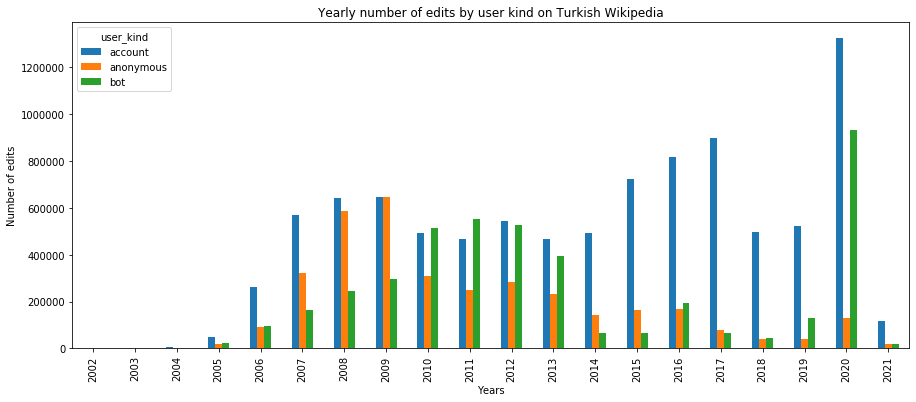

In [38]:
ax = yearly_edits['number_of_edits'].plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(15, 6)
# Change the axes labels
ax.set_title('Yearly number of edits by user kind on Turkish Wikipedia')
ax.set_xlabel("Years")
ax.set_ylabel("Number of edits")
plt.show()

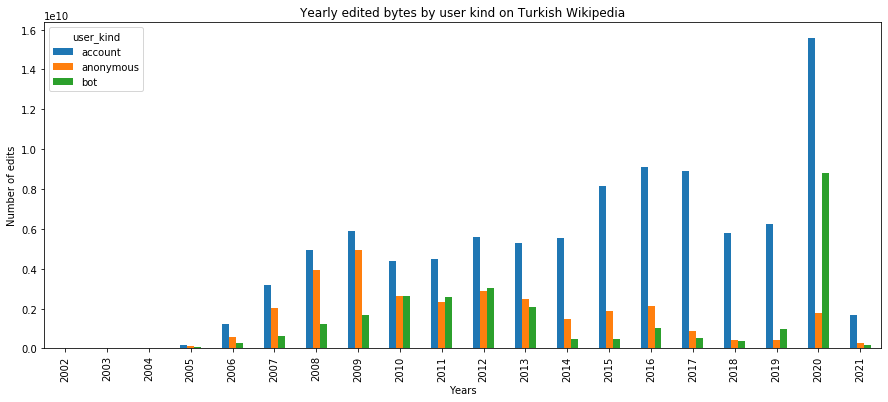

In [39]:
ax = yearly_edits["total_edited_bytes"].plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(15, 6)
# Change the axes labels
ax.set_title('Yearly edited bytes by user kind on Turkish Wikipedia')
ax.set_xlabel("Years")
ax.set_ylabel("Number of edits")
plt.show()

The number of edits seem to tell a different story than the new registrations. The registered editors of wikipedia contributed nearly as much in terms of content and more in terms of edits on 2017 (first year of the block) compared to 2016. A decrease is observed in the subsequent years but the decrease is less significant than the ones we had for the newcomers. For anonymous users the decrease is sharper as we saw in the case of newcomers. The bot activity seems relatively stable and low, and it doesn't seem to be used as a way to combat censorship.

In [40]:
daily_edits[daily_edits['user_kind'] == 'account'].sort_values('number_of_edits', ascending= False).head()

,date,user_kind,number_of_edits,total_edited_bytes
14802,2017-04-26 00:00:00+00:00,account,29441,178848137
9561,2012-07-14 00:00:00+00:00,account,18014,69166247
18096,2020-04-28 00:00:00+00:00,account,15499,122572087
18102,2020-04-30 00:00:00+00:00,account,15157,118701565
18111,2020-05-03 00:00:00+00:00,account,15001,109790144


In [41]:
daily_edits[(daily_edits['user_kind'] == 'account') & (daily_edits['date'] < '2017-04-20')].sort_values('number_of_edits', ascending= False).head()

,date,user_kind,number_of_edits,total_edited_bytes
9561,2012-07-14 00:00:00+00:00,account,18014,69166247
3993,2007-06-15 00:00:00+00:00,account,14320,42367213
3996,2007-06-16 00:00:00+00:00,account,14236,41834877
12774,2015-06-20 00:00:00+00:00,account,13164,98488883
11655,2014-06-12 00:00:00+00:00,account,9752,68069455


In [42]:
daily_edits = daily_edits[daily_edits['date'] >= block_dates[0]-pd.Timedelta(days=days_after_block)]

In [43]:
daily_edits['period'] = daily_edits.apply(lambda row: 'pre-block' if row['date'] < block_dates[0] else 'block' if not row['date'] >= block_dates[1] else 'after-block', axis=1)

In [44]:
registered_edits = daily_edits[daily_edits['user_kind'] == 'account'][['date', 'period', 'number_of_edits', 'total_edited_bytes']]
anonymous_edits = daily_edits[daily_edits['user_kind'] == 'anonymous'][['date','period', 'number_of_edits', 'total_edited_bytes']]
bot_edits = daily_edits[daily_edits['user_kind'] == 'bot'][['date','period', 'number_of_edits', 'total_edited_bytes']]

In [45]:
import matplotlib.dates as mdates

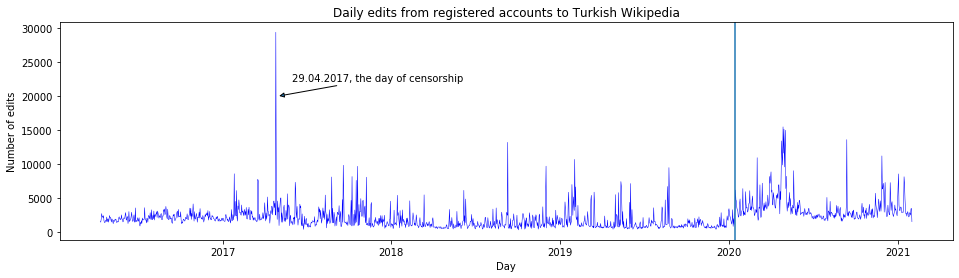

In [46]:
plt.figure(figsize=(16,4)) 
plt.title("Daily edits from registered accounts to Turkish Wikipedia")
plt.plot(registered_edits['date'].values, registered_edits['number_of_edits'], color='blue', lw=0.5)
plt.annotate('29.04.2017, the day of censorship', (mdates.date2num(block_dates[0]), 20000), xytext=(15, 15), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
plt.ylabel("Number of edits")
plt.xlabel("Day")
plt.axvline(block_dates[1])
plt.show()

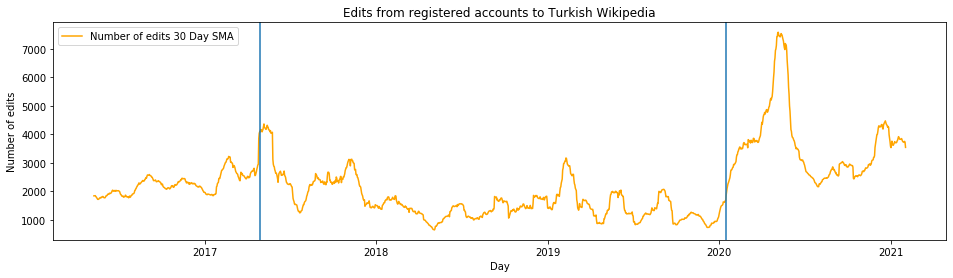

In [51]:
plt.figure(figsize=(16,4))
plt.title("Edits from registered accounts to Turkish Wikipedia")
rolling_mean = registered_edits['number_of_edits'].rolling(window=30).mean()
plt.plot(registered_edits['date'].values, rolling_mean, label='Number of edits 30 Day SMA', color='orange')
for date in block_dates:
    plt.axvline(date)
plt.ylabel("Number of edits")
plt.xlabel("Day")
plt.legend(loc='upper left')
plt.show()

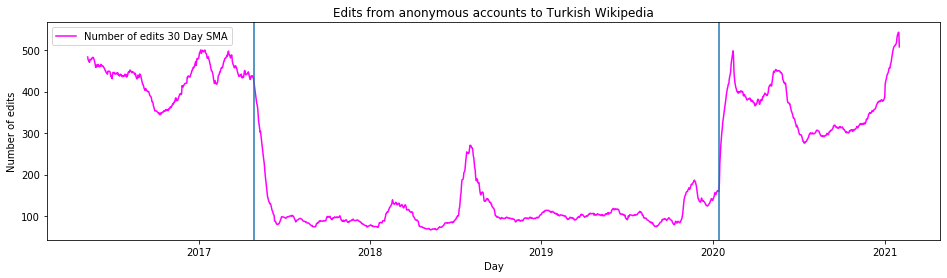

In [52]:
plt.figure(figsize=(16,4))
plt.title("Edits from anonymous accounts to Turkish Wikipedia")
rolling_mean = anonymous_edits['number_of_edits'].rolling(window=30).mean()
plt.plot(anonymous_edits['date'].values, rolling_mean, label='Number of edits 30 Day SMA', color='magenta')
for date in block_dates:
    plt.axvline(date)
plt.ylabel("Number of edits")
plt.xlabel("Day")
plt.legend(loc='upper left')
plt.show()

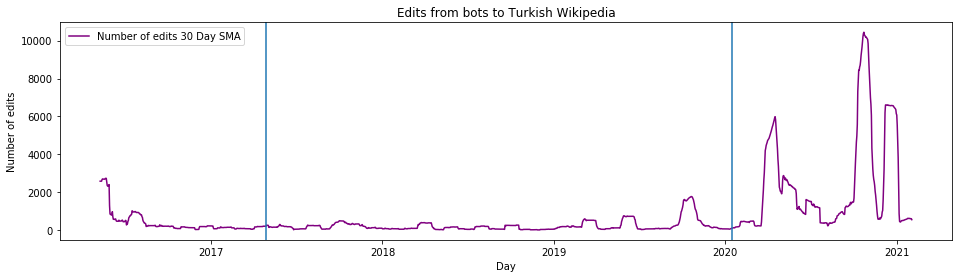

In [53]:
plt.figure(figsize=(16,4))
plt.title("Edits from bots to Turkish Wikipedia")
rolling_mean = bot_edits['number_of_edits'].rolling(window=30).mean()
plt.plot(bot_edits['date'].values, rolling_mean, label='Number of edits 30 Day SMA', color='purple')
for date in block_dates:
    plt.axvline(date)
plt.ylabel("Number of edits")
plt.xlabel("Day")
plt.legend(loc='upper left')
plt.show()

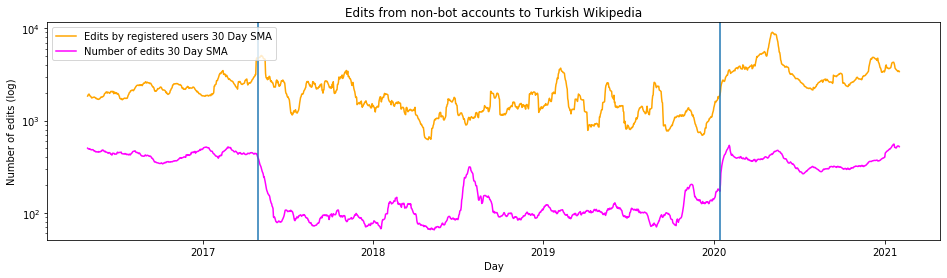

In [54]:
plt.figure(figsize=(16,4))
plt.title("Edits from non-bot accounts to Turkish Wikipedia")
rolling_mean = registered_edits['number_of_edits'].rolling(window=20).mean()
plt.plot(registered_edits['date'].values, rolling_mean, label='Edits by registered users 30 Day SMA', color='orange')
rolling_mean2 = anonymous_edits['number_of_edits'].rolling(window=20).mean()
plt.plot(anonymous_edits['date'].values, rolling_mean2, label='Number of edits 30 Day SMA', color='magenta')
for date in block_dates:
    plt.axvline(date)
    
plt.ylabel("Number of edits (log)")
plt.xlabel("Day")
plt.legend(loc='upper left')
plt.yscale('log')
plt.show()

Bot activity seems irrelevant. For registered accounts, number of edits doesn't fall as sharply as one can imagine. Anonymous edits drop sharply but recover once the ban is lifted.

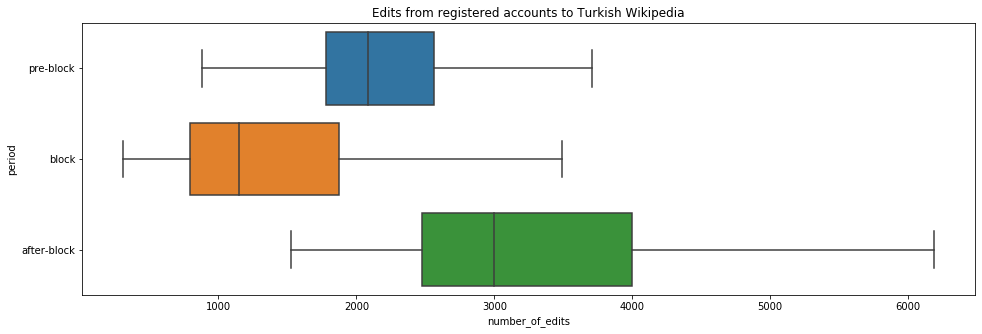

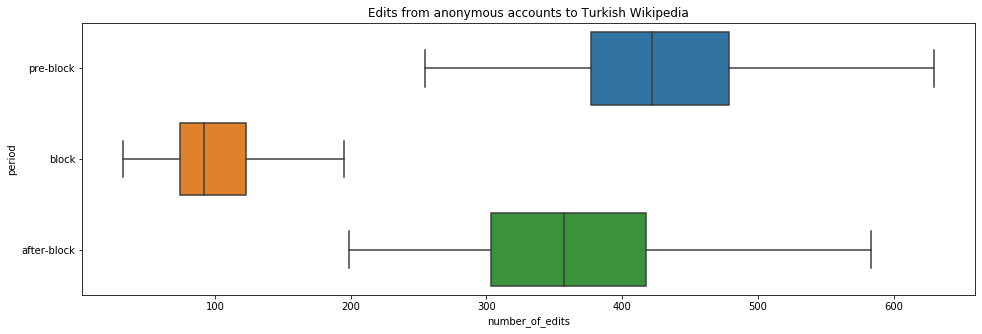

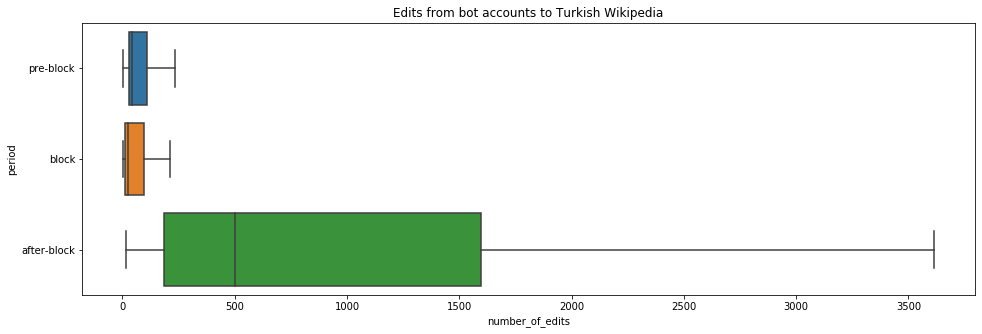

In [55]:
for df, name in [(registered_edits, 'registered'), (anonymous_edits, 'anonymous'), (bot_edits, 'bot')]:
    groups = df.groupby('period')
    periods = pd.concat([pd.DataFrame(x[1]['number_of_edits'].values) for x in groups], axis=1)
    periods = pd.DataFrame(periods)
    periods.columns = range(1,4)
    fig, ax = plt.subplots()
    plt.title(f"Edits from {name} accounts to Turkish Wikipedia")
    fig.set_size_inches(16, 5)
    plt.xlabel('Daily Edits')
    ax = sns.boxplot(y="period", x="number_of_edits", data=df,  showfliers=False)

### Analysis of distinct edited pages
I wanted to analyse if there was too much of a difference in trends between the number of edits and the number of distinct edited pages here. Nothing too significant seems to have come from this analysis.

In [56]:
edits.head()

,date,page_id,user_kind,number_of_edits,total_edited_bytes
0,2002-12-05 00:00:00+00:00,5,account,1,24
1,2002-12-05 00:00:00+00:00,2740662,anonymous,2,1819
2,2002-12-13 00:00:00+00:00,2740662,anonymous,2,1781
3,2002-12-16 00:00:00+00:00,2740662,anonymous,2,4766
4,2002-12-17 00:00:00+00:00,2740662,anonymous,1,4310


In [57]:
edited_pages = edits.groupby(['date', 'user_kind'])['page_id'].size()

In [58]:
edited_pages = edited_pages.reset_index()

In [59]:
edited_pages.columns = ['date','user_kind','distinct_page_id']

In [60]:
edited_pages = edited_pages[edited_pages['date'] >= block_dates[0]-pd.Timedelta(days=days_after_block)]
edited_pages['period'] = edited_pages.apply(lambda row: 'pre-block' if row['date'] < block_dates[0] else 'block' if not row['date'] >= block_dates[1] else 'after-block', axis=1)

In [61]:
registered_edited_pages = edited_pages[edited_pages['user_kind'] == 'account']
anonymous_edited_pages = edited_pages[edited_pages['user_kind'] == 'anonymous']
bot_edited_pages = edited_pages[edited_pages['user_kind'] == 'bot']

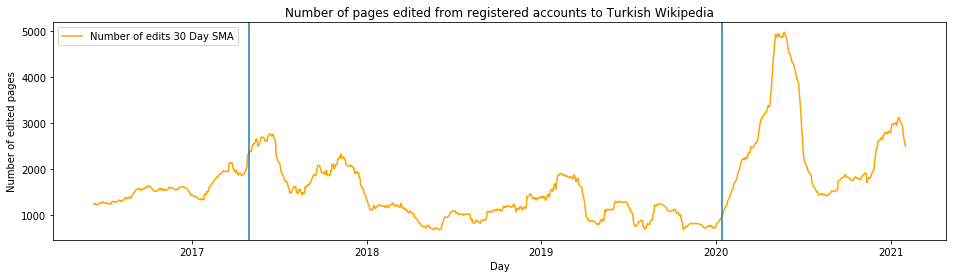

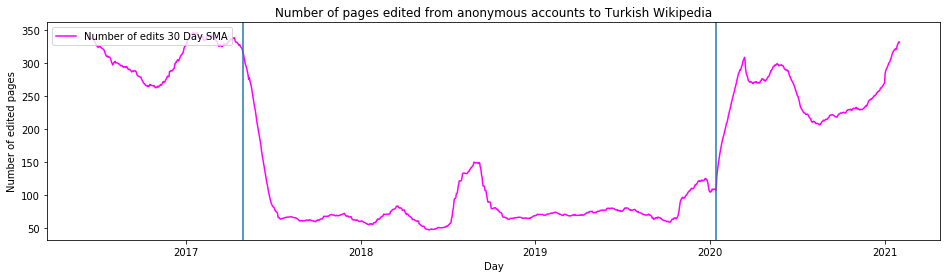

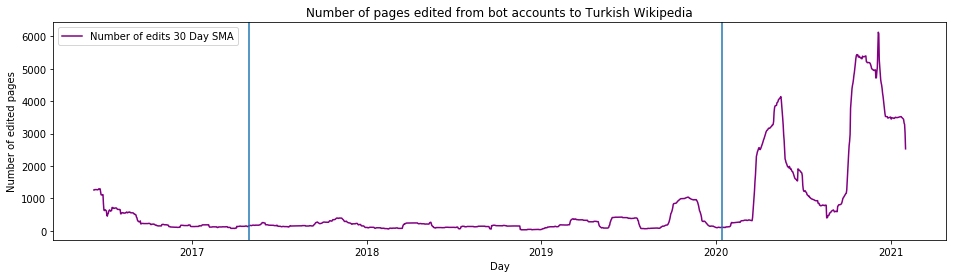

In [62]:
for df, name, color in [(registered_edited_pages, 'registered', 'orange'), (anonymous_edited_pages, 'anonymous', 'magenta'), (bot_edited_pages, 'bot', 'purple')]:
    plt.figure(figsize=(16,4))
    plt.title(f"Number of pages edited from {name} accounts to Turkish Wikipedia")
    rolling_mean = df['distinct_page_id'].rolling(window=60).mean()
    plt.plot(df['date'].values, rolling_mean, label='Number of edits 30 Day SMA', color=color)
    for date in block_dates:
        plt.axvline(date)
    plt.ylabel("Number of edited pages")
    plt.xlabel("Day")
    plt.legend(loc='upper left')
    plt.show()

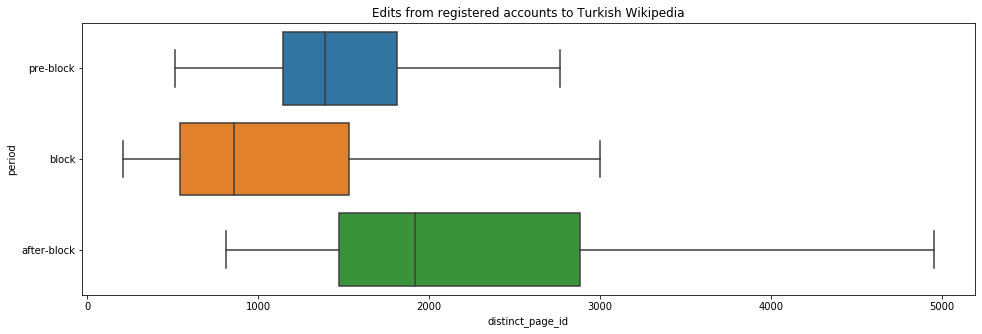

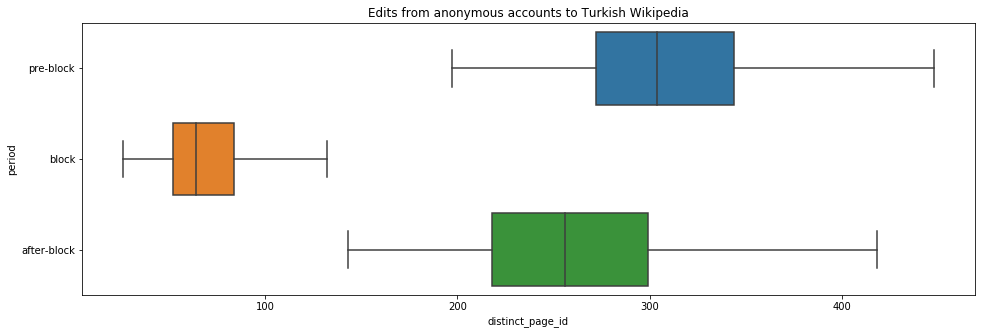

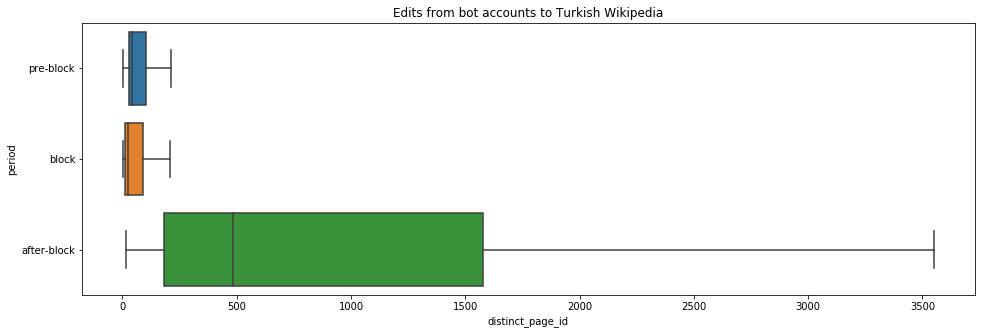

In [63]:
for df, name in [(registered_edited_pages, 'registered'), (anonymous_edited_pages, 'anonymous'), (bot_edited_pages, 'bot')]:
    groups = df.groupby('period')
    periods = pd.concat([pd.DataFrame(x[1]['distinct_page_id'].values) for x in groups], axis=1)
    periods = pd.DataFrame(periods)
    periods.columns = range(1,4)
    fig, ax = plt.subplots()
    plt.title(f"Edits from {name} accounts to Turkish Wikipedia")
    fig.set_size_inches(16, 5)
    plt.xlabel('Daily Edits')
    ax = sns.boxplot(y="period", x="distinct_page_id", data=df,  showfliers=False)

# 3) Reverts

## 1) Using Reverts (Reverts/Number of non bot edits)
In this first analysis I use the reverts which means if a given edit is a revert or not.
**Expectations** : Decrease in reverts due to the decrease in the number of newcomers and also due to the threat rigidity: shock -> more cohesion -> less reverts

In [99]:
reverts = pd.read_csv(f'{DATA_PATH}/processed_data/df_reverts.csv')

In [100]:
reverts.columns = ['date','user_kind','number_of_reverts']

In [101]:
reverts['date'] = pd.to_datetime(reverts['date'],   utc = True)

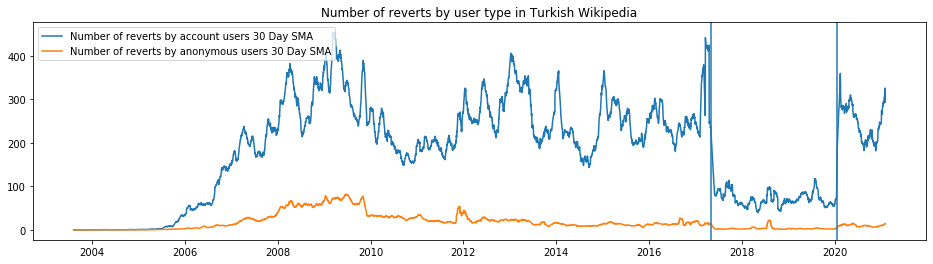

In [102]:
plt.figure(figsize=(16,4))

plt.title(f"Number of reverts by user type in Turkish Wikipedia")
for elem in ['account', 'anonymous']:
    df = reverts[reverts['user_kind'] == elem]
    rolling_mean = df['number_of_reverts'].rolling(window=30).mean()
    plt.plot(df['date'].values, rolling_mean, label=f'Number of reverts by {elem} users 30 Day SMA')
for date in block_dates:
    plt.axvline(date)
plt.legend(loc='upper left')
plt.show()

## Compute revert rate
**Revert Rate** =  number of identity reverts (by humans or bots) by the number of non-bot edits on this given day

In [103]:
daily_non_bot_edits = edits[edits['user_kind'] != 'bot'].groupby(['date'])[['number_of_edits']].sum()

In [104]:
daily_identity_reverts = reverts.groupby(['date'])[['number_of_reverts']].sum()

In [105]:
revert_rate = pd.merge(daily_identity_reverts, daily_non_bot_edits, on = 'date', how = 'outer')

In [106]:
revert_rate['revert_rate'] = revert_rate['number_of_reverts']/revert_rate['number_of_edits']

In [107]:
revert_rate =revert_rate.reset_index()

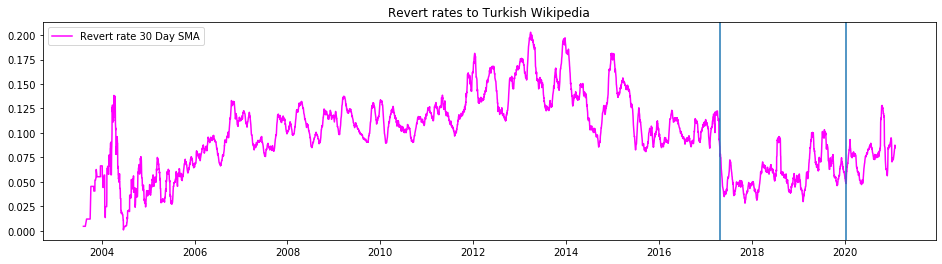

In [108]:
plt.figure(figsize=(16,4))
plt.title("Revert rates to Turkish Wikipedia")
rolling_mean = revert_rate['revert_rate'].rolling(window=30).mean()
plt.plot(revert_rate['date'].values, rolling_mean, label='Revert rate 30 Day SMA', color='magenta')
for date in block_dates:
    plt.axvline(date)
plt.legend(loc='upper left')
plt.show()

In [109]:
revert_rate = revert_rate[revert_rate['date'] >= block_dates[0]-pd.Timedelta(days=days_after_block)]
revert_rate['period'] = revert_rate.apply(lambda row: 'pre-block' if row['date'] < block_dates[0] else 'block' if not row['date'] >= block_dates[1] else 'after-block', axis=1)

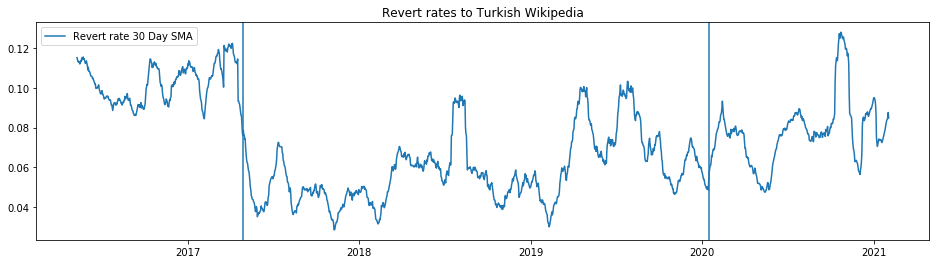

In [110]:
plt.figure(figsize=(16,4))
plt.title("Revert rates to Turkish Wikipedia")
for window in [30]:
    rolling_mean = revert_rate['revert_rate'].rolling(window=window).mean()
    plt.plot(revert_rate['date'].values, rolling_mean, label=f'Revert rate {window} Day SMA')

for date in block_dates:
    plt.axvline(date)
plt.legend(loc='upper left')
plt.show()

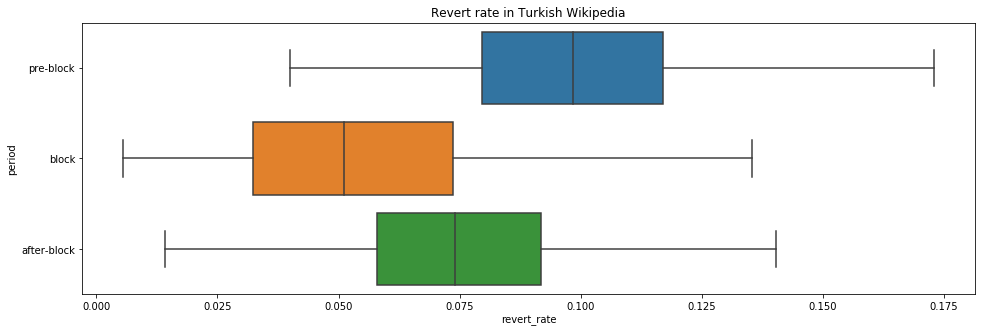

In [111]:
groups = revert_rate.groupby('period')
periods = pd.concat([pd.DataFrame(x[1]['revert_rate'].values) for x in groups], axis=1)
periods = pd.DataFrame(periods)
periods.columns = range(1,4)
fig, ax = plt.subplots()
plt.title(f"Revert rate in Turkish Wikipedia")
fig.set_size_inches(16, 5)
ax = sns.boxplot(y="period", x="revert_rate", data=revert_rate,  showfliers=False)

The median for the revert rate goes down 3x between pre-block and block periods while the number of newcomers goes down by 10x. This could suggest the cohesion effect is real. We have to look into more detail about the newcomers and the number of edits they make and also look at the percent of reverts they receive compared to other users in this period.

## 2) Using Reverted pages (Reverts/Number of non bot edits)
Here we look at if a edit made on a given day was subsequently reverted.

In [86]:
reverts = pd.read_csv(f'{DATA_PATH}/processed_data/df_reverted.csv')

In [87]:
reverts.columns = ['date','user_kind','number_of_reverts']

In [88]:
reverts['date'] = pd.to_datetime(reverts['date'],   utc = True)

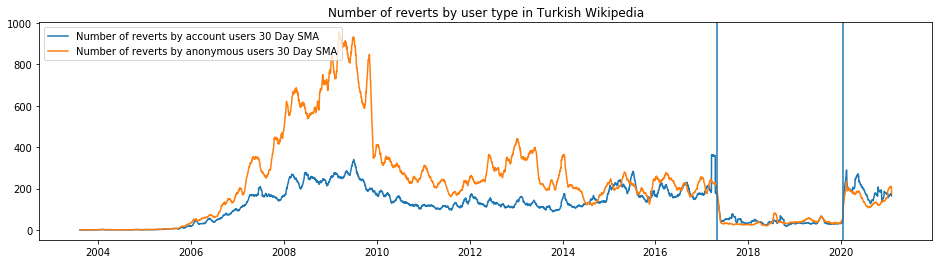

In [89]:
plt.figure(figsize=(16,4))

plt.title(f"Number of reverts by user type in Turkish Wikipedia")
for elem in ['account', 'anonymous']:
    df = reverts[reverts['user_kind'] == elem]
    rolling_mean = df['number_of_reverts'].rolling(window=30).mean()
    plt.plot(df['date'].values, rolling_mean, label=f'Number of reverts by {elem} users 30 Day SMA')
for date in block_dates:
    plt.axvline(date)
plt.legend(loc='upper left')
plt.show()

## Compute revert rate
**Revert Rate** =  number of edits on a given day which were later reverted (by humans or bots) by the number of non-bot edits on this given day.
This signal would potentially indicate the quality of edits made during a day. If the revert rate is low, we can say that most of the edits made during that day were of good quality and were not subsequently undone.

In [90]:
daily_non_bot_edits = edits[edits['user_kind'] != 'bot'].groupby(['date'])[['number_of_edits']].sum()

In [91]:
daily_identity_reverts = reverts.groupby(['date'])[['number_of_reverts']].sum()

In [92]:
revert_rate = pd.merge(daily_identity_reverts, daily_non_bot_edits, on = 'date', how = 'outer')

In [93]:
revert_rate['revert_rate'] = revert_rate['number_of_reverts']/revert_rate['number_of_edits']

In [94]:
revert_rate =revert_rate.reset_index()

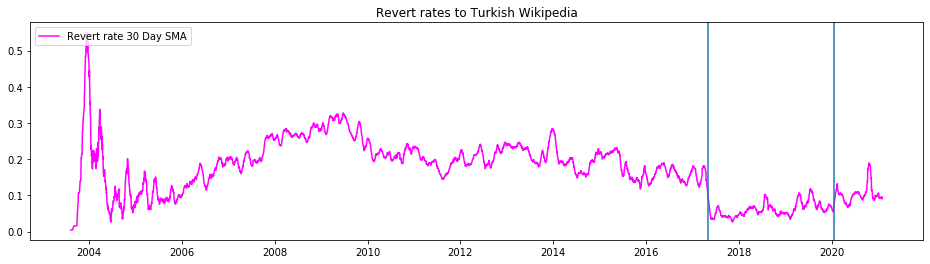

In [95]:
plt.figure(figsize=(16,4))
plt.title("Revert rates to Turkish Wikipedia")
rolling_mean = revert_rate['revert_rate'].rolling(window=30).mean()
plt.plot(revert_rate['date'].values, rolling_mean, label='Revert rate 30 Day SMA', color='magenta')
for date in block_dates:
    plt.axvline(date)
plt.legend(loc='upper left')
plt.show()

In [96]:
revert_rate = revert_rate[revert_rate['date'] >= block_dates[0]-pd.Timedelta(days=days_after_block)]
revert_rate['period'] = revert_rate.apply(lambda row: 'pre-block' if row['date'] < block_dates[0] else 'block' if not row['date'] >= block_dates[1] else 'after-block', axis=1)

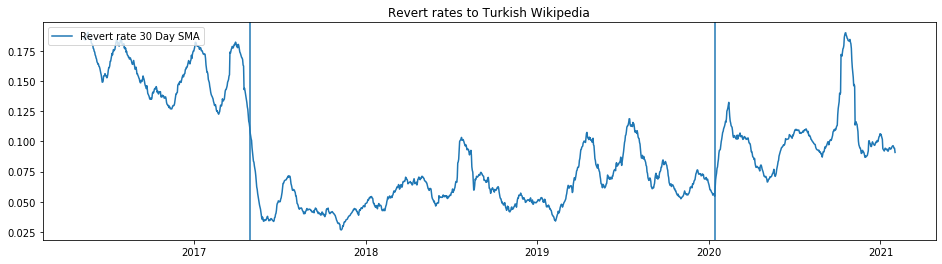

In [97]:
plt.figure(figsize=(16,4))
plt.title("Revert rates to Turkish Wikipedia")
for window in [30]:
    rolling_mean = revert_rate['revert_rate'].rolling(window=window).mean()
    plt.plot(revert_rate['date'].values, rolling_mean, label=f'Revert rate {window} Day SMA')

for date in block_dates:
    plt.axvline(date)
plt.legend(loc='upper left')
plt.show()

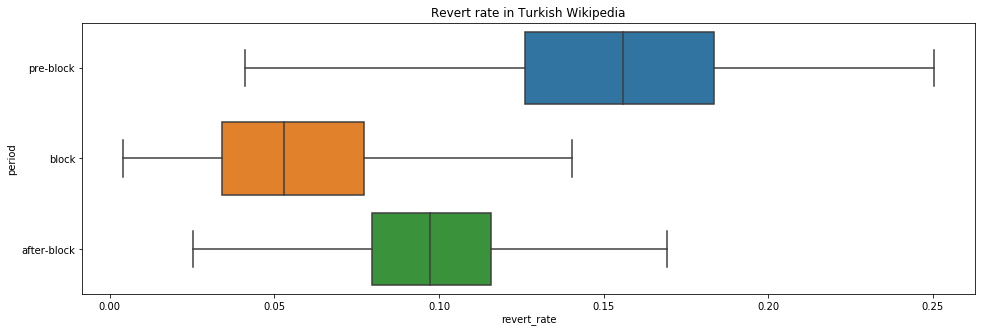

In [98]:
groups = revert_rate.groupby('period')
periods = pd.concat([pd.DataFrame(x[1]['revert_rate'].values) for x in groups], axis=1)
periods = pd.DataFrame(periods)
periods.columns = range(1,4)
fig, ax = plt.subplots()
plt.title(f"Revert rate in Turkish Wikipedia")
fig.set_size_inches(16, 5)
ax = sns.boxplot(y="period", x="revert_rate", data=revert_rate,  showfliers=False)

We see a decrease of this revert rate too. In further analysis we should try to understand if this is a conscious response to the shock (for example users prioritizing quantity over quality checks) or if the ban naturally removed users producing articles of lesser quality decreasing the revert rate. 